# **Model Training**

In [ ]:
#Dataset-download
!git clone https://github.com/ML9-FORCES/extractify-doc

In [ ]:
#library - (Required in Usage & training)
!pip install transformers
from transformers import BertTokenizer
import tensorflow as tf
import numpy as np

#library - (Required in training only)
!pip install scikit-plot
import scikitplot as skplt
import sklearn.metrics as metrics
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

#Helper-function 

#Dynamic Encoder & Decoder for classes
def hot_encode(value):
  encode={'question': 1 ,'other': 0, 'header': 0, 'answer': 2}
  decode={1:'key',2:'value',0:'other'}
  try:
    return encode[value]
  except:
    return decode[value]

#Wrappper for Post & Pre Processing over Model Usage.
def predict(text,seq_len=50,mode=0):
    tokens = tokenizer.encode_plus(text, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    in_tensor = {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}
    probs = model.predict(in_tensor)[0]
    if mode ==1:
      return probs
    return np.argmax(probs)

#Extracts Data From Dataset
def extract(path):
  arr =[]
  for filename in os.listdir(path):
    f = os.path.join(path, filename)
    if os.path.isfile(f):
      file_ = open(f)
      data = json.load(file_)
      file_.close()
      for i in data['form']:
        arr.append([i['text'],hot_encode(i['label'])])
  df = pd.DataFrame(data = np.array(arr), columns = ['text', 'label'])
  return df

#Processing Data-Frames to TensorData with batch & Shuffle
def tf_data(df,seq_len=246,batch_size=16,suffle=10000):
  num_samples = len(df)
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  for i, phrase in enumerate(df['text']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']
  df['label'] = df['label'].astype(int)
  arr = df['label'].values
  labels = np.zeros((num_samples, arr.max()+1))
  labels[np.arange(num_samples), arr] = 1
  dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
  def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
  dataset = dataset.map(map_func)
  dataset = dataset.shuffle(suffle).batch(batch_size, drop_remainder=True)
  return dataset

#For Ploting Loss & Accuracy Curves
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
#Parameters
seq_len=50
batch_size=16
suffle=10000
node=1024
learning_rate=1e-5
decay=1e-6

#Data_Frames-Extraction
train_data = extract('extractify-doc/dataset/training_data/annotations')
test_data = extract('extractify-doc/dataset/testing_data/annotations')

#Tensor-dataset
train_ds = tf_data(train_data,seq_len,batch_size,suffle)
val_ds = tf_data(test_data,seq_len,batch_size,suffle)

In [ ]:
#Building-Model
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]
x = tf.keras.layers.Dense(node, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
#model.layers[2].trainable = False # (optional) freeze bert layer
optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
#model-summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [ ]:
#model-fit
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
463/463 [==============================] - 199s 401ms/step - loss: 0.6915 - accuracy: 0.7261 - val_loss: 0.5184 - val_accuracy: 0.8017
Epoch 2/3
463/463 [==============================] - 183s 394ms/step - loss: 0.5185 - accuracy: 0.8079 - val_loss: 0.5049 - val_accuracy: 0.8086
Epoch 3/3
463/463 [==============================] - 182s 394ms/step - loss: 0.4201 - accuracy: 0.8460 - val_loss: 0.5005 - val_accuracy: 0.8121


In [ ]:
#saving_model
model.save('MODEL/classifier')
#model.save('/content/drive/MyDrive/MODELS/classifier')

# **Model-Metrics**

(0.0, 1.0)

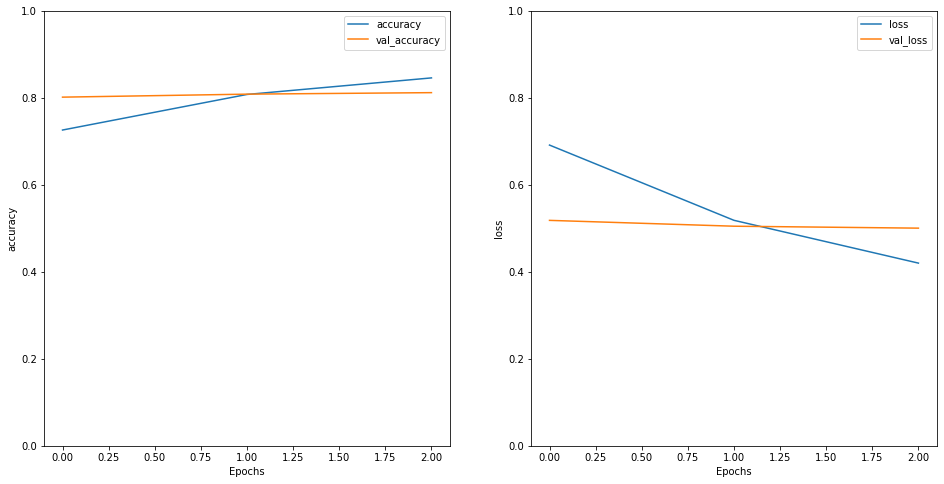

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, 1)

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

145/145 [==============================] - 17s 114ms/step - loss: 0.5001 - accuracy: 0.8125
Test Loss: 0.5000534057617188
Test Accuracy: 0.8125


In [ ]:
y_true=np.array([int(i) for i in test_data['label']])
y_prob=np.array([predict(i,seq_len,1) for i in test_data['text']])
y_pred=np.array([np.argmax(i) for i in y_prob])

In [ ]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       434
           1       0.87      0.87      0.87      1077
           2       0.87      0.82      0.85       821

    accuracy                           0.81      2332
   macro avg       0.78      0.78      0.78      2332
weighted avg       0.82      0.81      0.81      2332



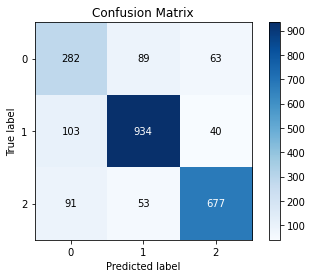

In [ ]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred)
plt.show()

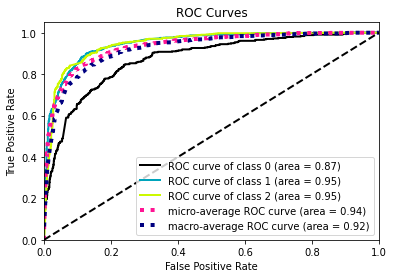

In [ ]:
skplt.metrics.plot_roc(y_true,y_prob)

In [ ]:
f1_score=metrics.f1_score(y_true,y_pred,average=None)
print('F1-Score')
print('class(0) : Other :',f1_score[0])
print('class(1) : Key :',f1_score[1])
print('class(2) : Value :',f1_score[2])

F1-Score
class(0) : Other : 0.6197802197802198
class(1) : Key : 0.8676265675801209
class(2) : Value : 0.8457214241099312


# **Model-Usage**

In [1]:
#external requirement
!pip install transformers
!pip install gdown==4.1.1

     |████████████████████████████████| 3.4 MB 12.5 MB/s 
     |████████████████████████████████| 596 kB 25.1 MB/s 
     |████████████████████████████████| 61 kB 497 kB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 41.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.1.1-py3-none-any.whl size=14211 sha256=904aeed3500d45057cfc662e5a317ebd0ec97fae410a42879a2e04f1ebd107b6
  Stored in directory: /root/.cache/pip/wheels/0c/45/5c/0c6bf549923e217b4a0fd24a90ce36e0d183ca50b7a1a7306d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [2]:
#Library
from transformers import BertTokenizer
import tensorflow as tf
import numpy as np
import gdown
import os

In [6]:
#bert_classifier Class
class bert_classifier:
    def __init__(self):
        path='./static/MODELS/bert_classifier'
        url='https://drive.google.com/drive/folders/1u8pPnb2qPTt67Yf3v8enC2pF2HpyWaEc'
        if not os.path.isdir(path):
            gdown.download_folder(url,output=path, quiet=False)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.model = tf.keras.models.load_model(path) 

    def preprocessing(self, input_data):
        tokens = self.tokenizer.encode_plus(input_data, max_length=50,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
        # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
        in_tensor = {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}
        return in_tensor 

    def predict(self, input_data):
        return self.model.predict(input_data)[0]

    def postprocessing(self, input_data):
        bins={1:'key',2:'value',0:'other'}
        return bins[np.argmax(input_data)],str(np.max(input_data))

    def compute_prediction(self, input_data):
        try:
            input_data = self.preprocessing(input_data)
            prediction = self.predict(input_data)
            prediction = self.postprocessing(prediction)
        except Exception as e:
            return {"status": "Error", "message": str(e)}
        return prediction

In [7]:
#Intialize Model-Object
classifier = bert_classifier()

In [8]:
text='DATE'
prediction=classifier.compute_prediction(text)
print(prediction) #(label,confidence)

('key', '0.9858148')
